**PACKAGES**

In [145]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import signal
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
import statsmodels.tsa.stattools as st
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR
from statsmodels.stats.diagnostic import acorr_ljungbox
import seaborn as sns
from statsmodels.stats.stattools import durbin_watson
import warnings
warnings.filterwarnings("ignore")

**PART 1:** Loading, converting and cleaning of the data.

Convert the dataset into a pandas dataframe. The column utc_timestamp will be the index of the dataframe I'm going to use.

In [117]:
wind_energy = pd.read_csv('WindEnergy.csv', sep=',', parse_dates=['utc_timestamp'], index_col='utc_timestamp')
wind_energy = wind_energy.asfreq('d') 
wind_energy

,wind_generation_actual,wind_capacity,temperature
utc_timestamp,,,
2017-01-01 00:00:00+00:00,291760.0,37149.130,-2.117
2017-01-02 00:00:00+00:00,295097.0,37152.125,-1.154
2017-01-03 00:00:00+00:00,666170.0,37155.208,-0.239
2017-01-04 00:00:00+00:00,686581.0,37160.125,0.620
2017-01-05 00:00:00+00:00,261759.0,37163.542,-3.908
...,...,...,...
2019-12-26 00:00:00+00:00,132739.0,50424.125,2.790
2019-12-27 00:00:00+00:00,146590.0,50427.000,1.327
2019-12-28 00:00:00+00:00,159126.0,50427.292,-1.441


Looking more into the dataset we see that it has three different features.
- wind_generation_actual: power generated by the turbines in Germany on that day;
- temperature: mean temperature on that day;
-  wind_Capacity: total amunt of power generate through a time interval

Now, we want to clear the dataset

In [118]:
wind_energy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1094 entries, 2017-01-01 00:00:00+00:00 to 2019-12-30 00:00:00+00:00
Freq: D
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   wind_generation_actual  1094 non-null   float64
 1   wind_capacity           1094 non-null   float64
 2   temperature             1094 non-null   float64
dtypes: float64(3)
memory usage: 34.2 KB


In [119]:
wind_energy.isnull().sum()

wind_generation_actual    0
wind_capacity             0
temperature               0
dtype: int64

The dataset is clean and without null values, there is no need to preprocessing to the data as it is right now. 
The next move is to capture some information about the individual features.

In [120]:
wind_energy.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
wind_generation_actual,1094.0,305819.77,205728.86,16482.00,148552.75,254332.50,412570.50,998899.00
wind_capacity,1094.0,45066.02,4315.84,37149.13,41447.94,46073.00,49203.00,50452.00
temperature,1094.0,10.05,7.74,-9.36,3.58,10.05,16.57,28.24


We can see that the wind_generation_actual is the feature with the highest values, while the temperature is the lowest one.

**PART 2:** Exploring the dataset with descriptive statistics and frequency analysis. Use appropriate graphs to visualise the data at hand

At the fisrt, we're going to analyze the single features in search of informations, patterns and characteristics of which the dataset is made of. 

For time series data, the most often used graph to start is the *Time graph*. In this graph, observations are plotted against observation time, with consecutive observations joined by straight lines.

**A. Wind_generation_actual**

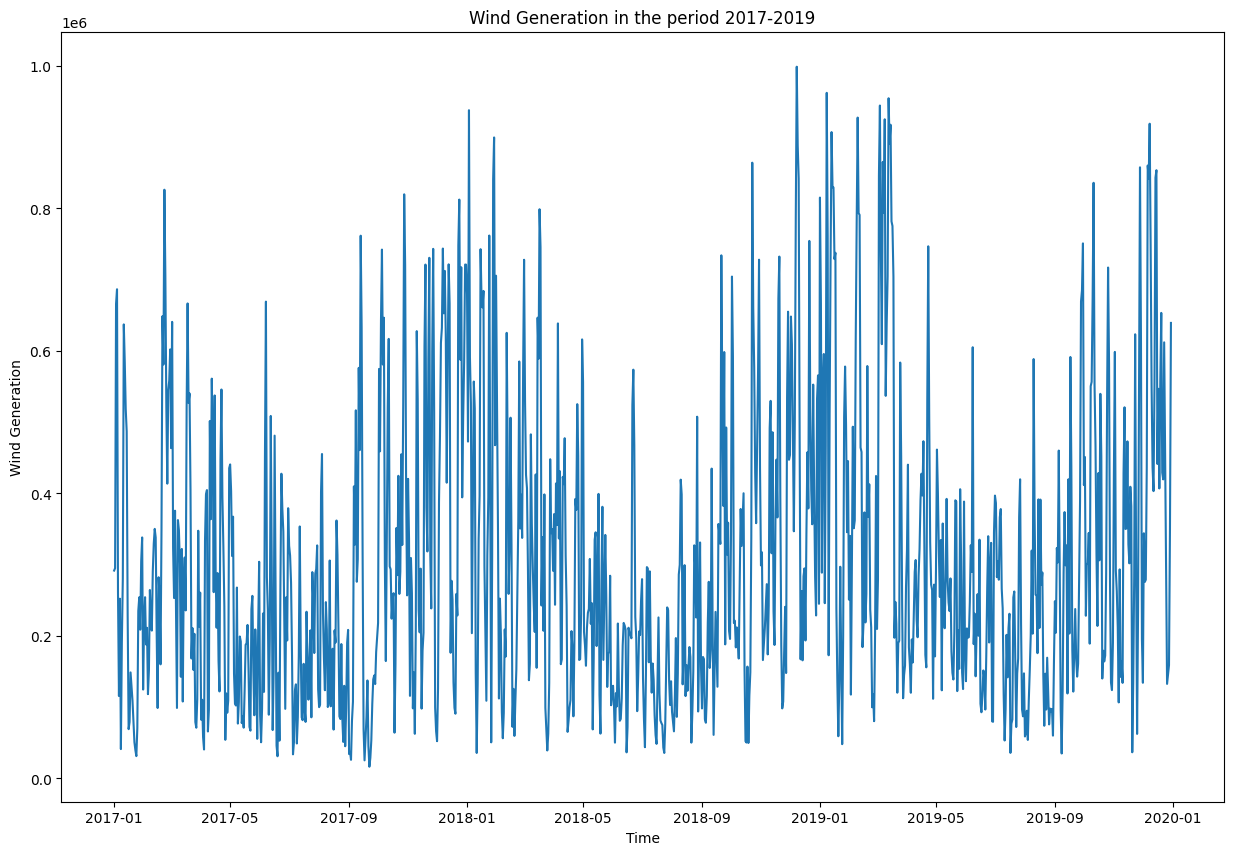

In [121]:
plt.figure(figsize=(15,10))
sns.lineplot(data= wind_energy, x='utc_timestamp', y='wind_generation_actual')
plt.ylabel("Wind Generation")
plt.xlabel("Time")
plt.title("Wind Generation in the period 2017-2019")
plt.show()

From here it can be seen that in all three years, the summer season (May to September) has the lowest wind generation while the winter season (September to April) has the highest. There is a certain seasonality in the data, visible from the recurring patterns, and probably also a cyclical component.

**B. Wind_Capacity**

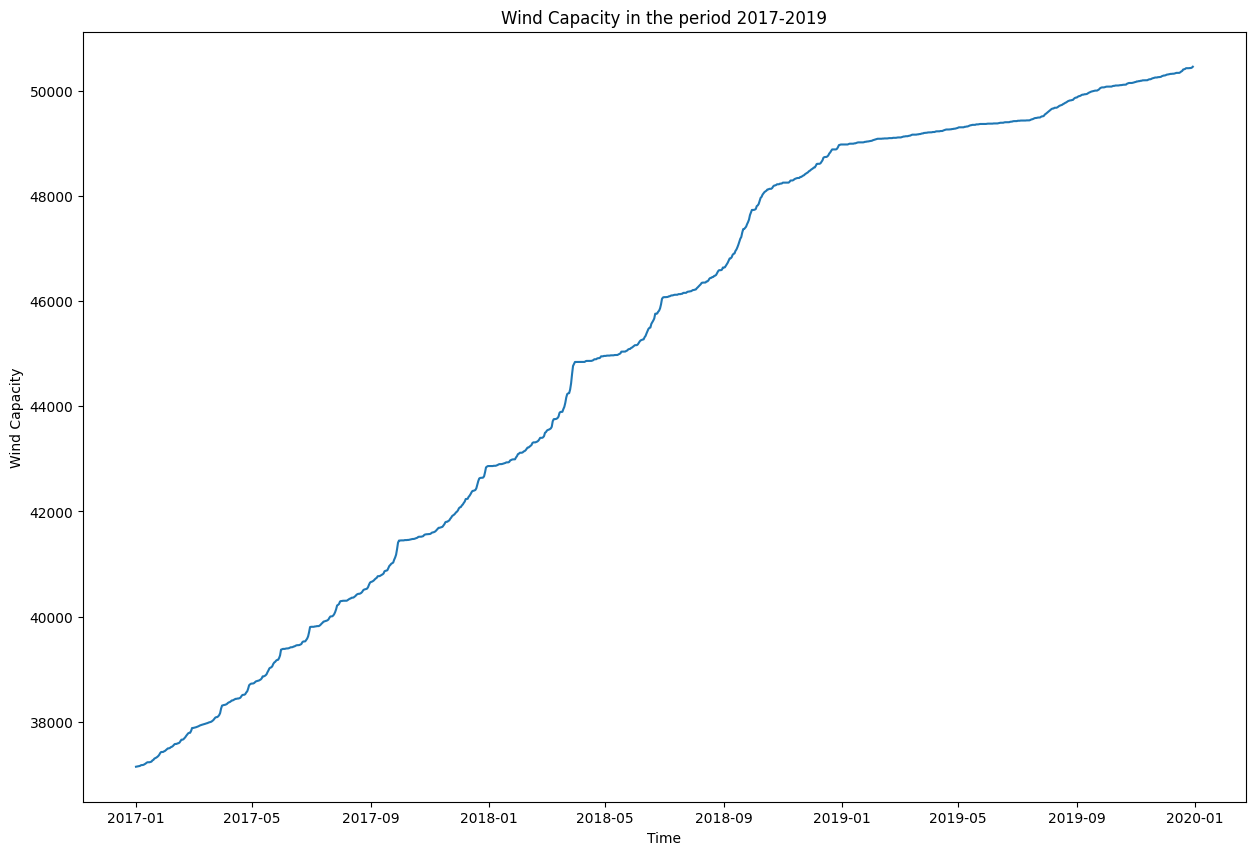

In [122]:
plt.figure(figsize=(15,10))
sns.lineplot(data=wind_energy, x='utc_timestamp', y='wind_capacity')
plt.ylabel("Wind Capacity")
plt.xlabel("Time")
plt.title("Wind Capacity in the period 2017-2019")
plt.show()


From this graph, however, it can be seen that there is a recurring 'wave' pattern that starts fairly slowly in 2017, but laver, between the ylast two years, the waves become a little longer and higher.

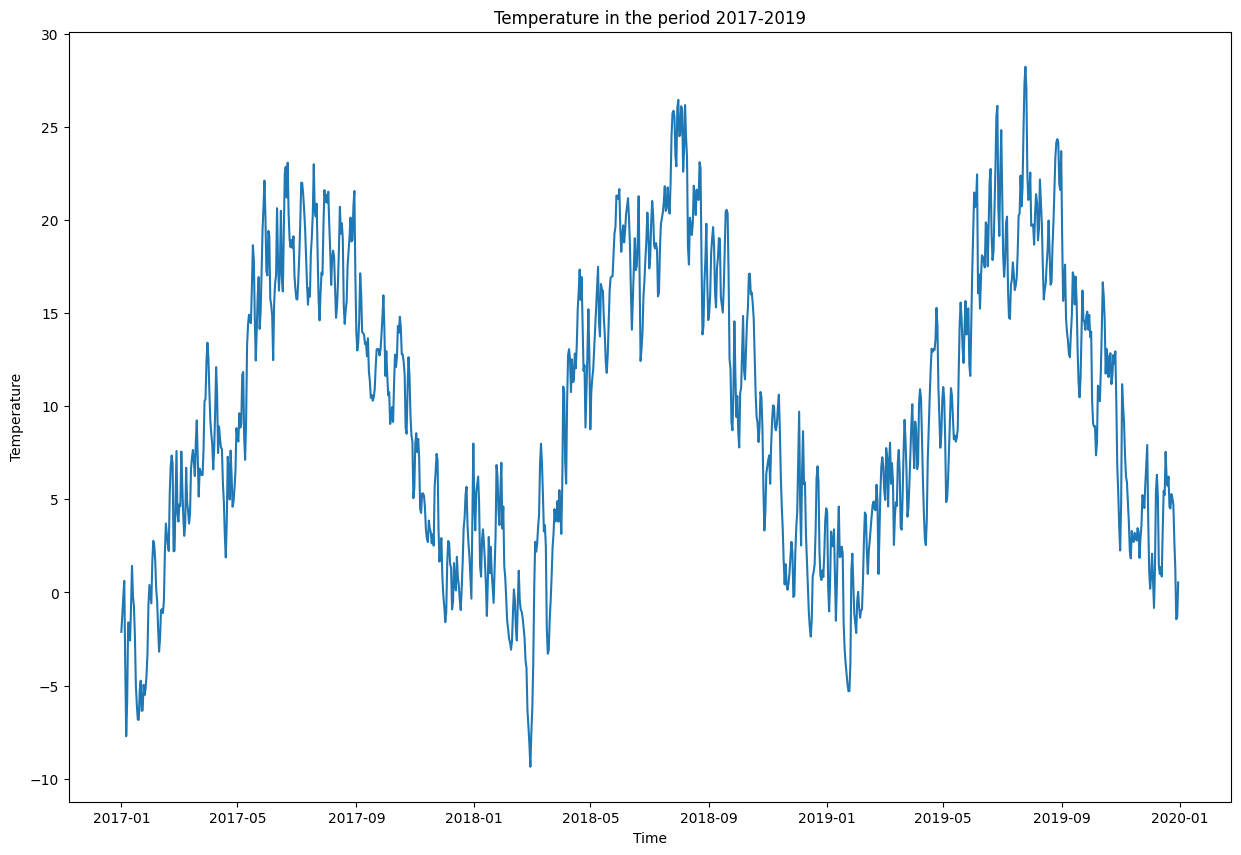

In [123]:
plt.figure(figsize=(15,10))
sns.lineplot(data = wind_energy, x='utc_timestamp', y='temperature')
plt.ylabel("Temperature")
plt.xlabel("Time")
plt.title("Temperature in the period 2017-2019")
plt.show()

This graph shows the temperature trend over the last three years, highlighting a recurring seasonal pattern, which can be seen from the three ‘peaks’. Each year, temperatures are lowest in the winter months, gradually rise in the spring until they peak in the summer, then fall again in the autumn and return to their lowest values in the winter. This cycle repeats itself regularly, indicating a marked climatic seasonality.

Next, we will analyse the distribution of the variables by means of a *histogram* graph

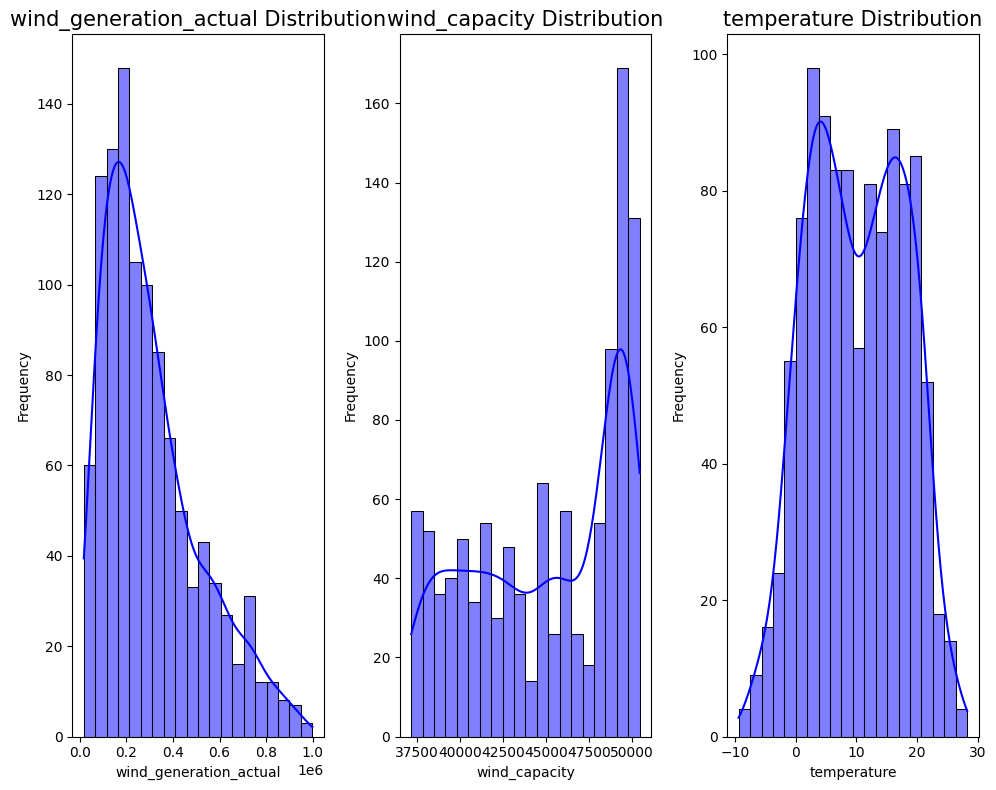

In [124]:
variables = wind_energy.columns
n_vars = len(variables)
fig, axes = plt.subplots(1,3,figsize=(10,8))
for i, var in enumerate(variables):
    sns.histplot(wind_energy[var], bins=20, kde=True, ax=axes[i], color='Blue')
    axes[i].set_title(f'{var} Distribution', fontsize=15)
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Frequency')
    
plt.tight_layout()
plt.show()

Next, we visualise the distribution of variables and the presence of outliers using a *Boxplot* and *Violinplot* graph.

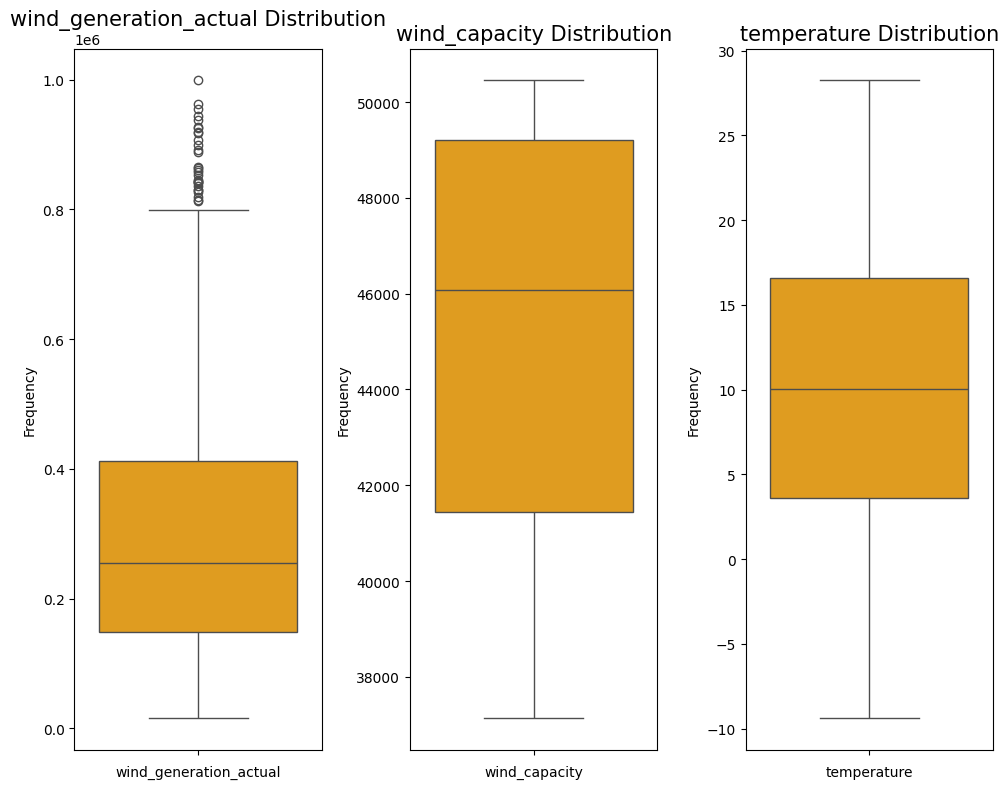

In [125]:
fig, axes = plt.subplots(1,3,figsize=(10,8))
for i, var in enumerate(variables):
    sns.boxplot(y=wind_energy[var], ax=axes[i], color='Orange')
    axes[i].set_title(f'{var} Distribution', fontsize=15)
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Frequency')
    
plt.tight_layout()
plt.show()

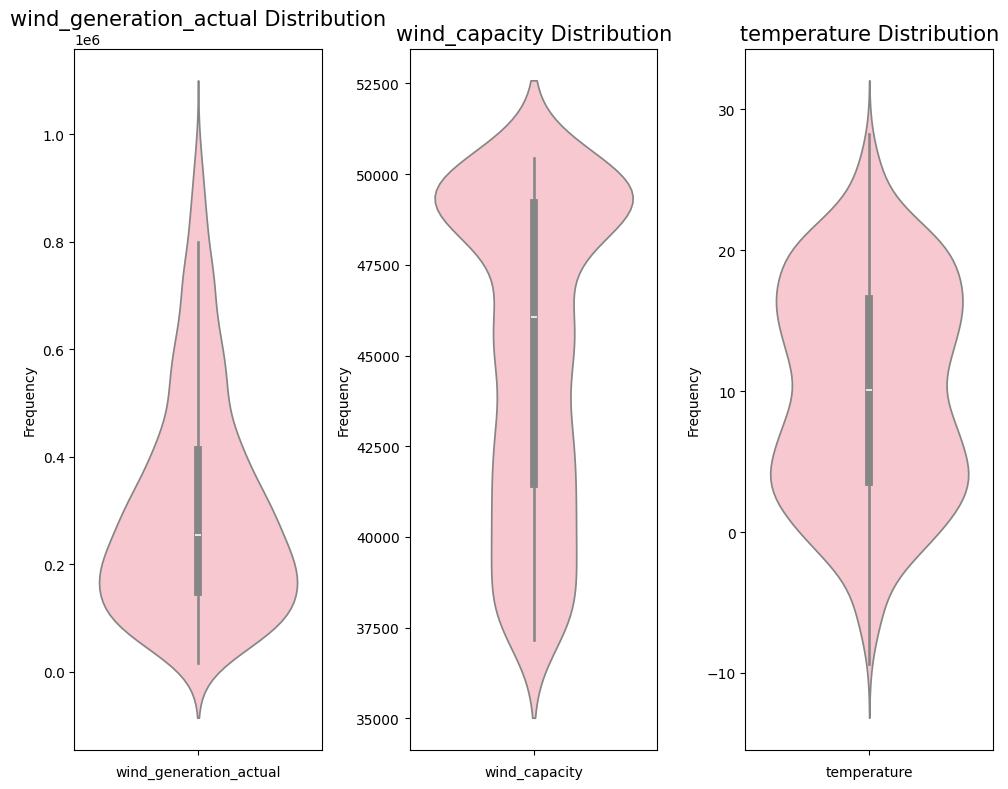

In [126]:
fig, axes = plt.subplots(1,3,figsize=(10,8))
for i, var in enumerate(variables):
    sns.violinplot(y=wind_enenrgy[var], ax=axes[i], color='Pink')
    axes[i].set_title(f'{var} Distribution', fontsize=15)
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Frequency')
    
plt.tight_layout()
plt.show()

We see that there are some outliers in the wind generation. Let's investigate more by calculating the *IQR* and then determine the total numbers of outliers.

In [127]:
Q1_py = np.quantile(wind_energy.wind_generation_actual,0.25)
Q3_py = np.quantile(wind_energy.wind_generation_actual,0.75)
IQR = Q3_py-Q1_py
Lower_Fence = Q1_py - 1.5*IQR
Upper_Fence = Q3_py + 1.5*IQR

T = []
for i in wind_energy.wind_generation_actual:
    exp1 = i < Lower_Fence
    exp2 = i > Upper_Fence
    if exp1 or exp2:
       temp = i
       T.append(temp)
print('The total number of outliers is ', len(T), 'which is rougly', round(len(T)/len(wind_enenrgy)*100,2), '% of the dataset')

The total number of outliers is  30 which is rougly 2.74 % of the dataset


Another interesting thing to see is if there is correlations between the variables with the *Heatmap*. This will be useful in determining the type of model we are going to use to forecast data.

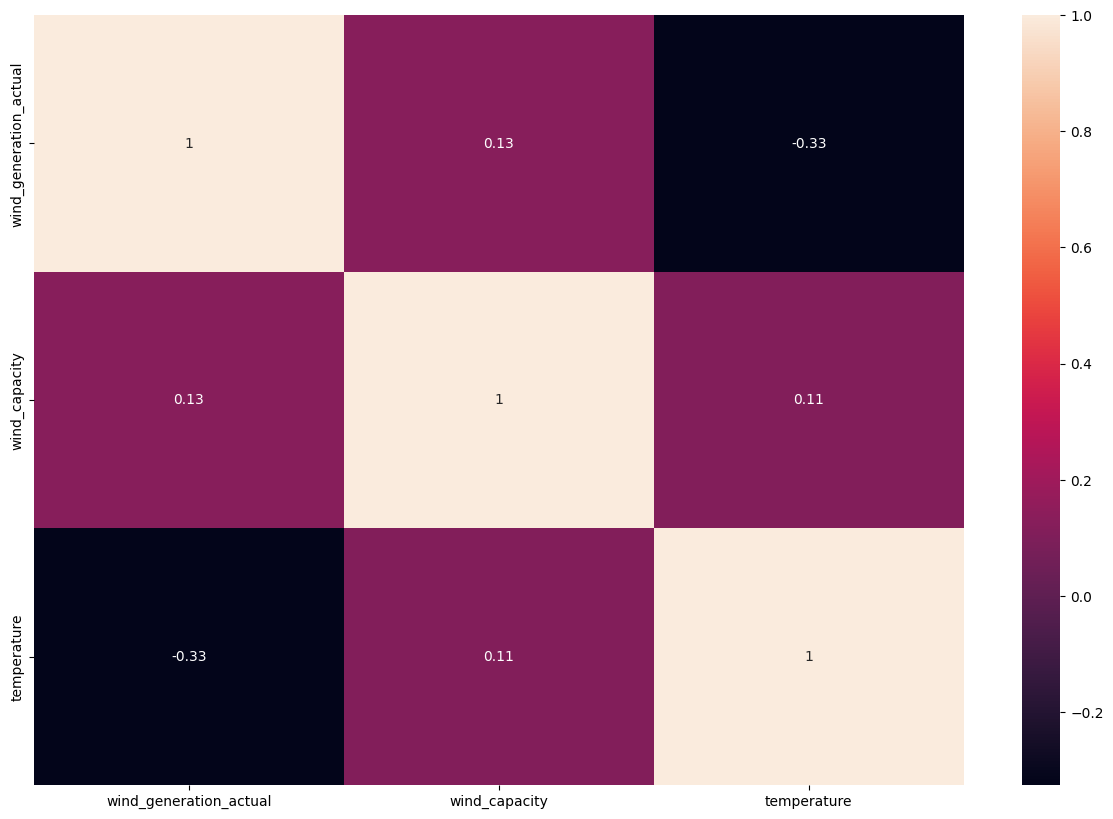

In [128]:
plt.figure(figsize=(15,10))
corr = wind_energy.corr()
sns.heatmap(corr,annot=True)
plt.show()

It's possible to see that the data does not present strong correlation between the features. There is a slighly negative correlation between the wind_generation and the temperature. 

**SLIPT OF THE DATA**

From the document 'The main aim of this project is to forecast the wind power generation for the last month of 2019 (December)'. So the test set is going to be only the month of december 2019 and the train set will be the other part.

In [129]:
#Splitting the data in the train and test set. The month of december 2019 is going to be out test set.
train_data = wind_energy[:'2019-12-01']
test_data = wind_energy['2019-12-01':]
wind_generation_train = wind_energy['wind_generation_actual'][:'2019-12-01']
wind_generation_test = wind_energy['wind_generation_actual']['2019-12-01':]

print('Shape of the splotted dataset: ', '\nTrain: ', wind_generation_train.shape, '\nTest: ', wind_generation_test.shape)
print(wind_generation_train.head())
print(wind_generation_test.head())

Shape of the splotted dataset:  
Train:  (1065,) 
Test:  (30,)
utc_timestamp
2017-01-01 00:00:00+00:00    291760.0
2017-01-02 00:00:00+00:00    295097.0
2017-01-03 00:00:00+00:00    666170.0
2017-01-04 00:00:00+00:00    686581.0
2017-01-05 00:00:00+00:00    261759.0
Freq: D, Name: wind_generation_actual, dtype: float64
utc_timestamp
2019-12-01 00:00:00+00:00    134296.0
2019-12-02 00:00:00+00:00    344119.0
2019-12-03 00:00:00+00:00    275830.0
2019-12-04 00:00:00+00:00    278977.0
2019-12-05 00:00:00+00:00    436209.0
Freq: D, Name: wind_generation_actual, dtype: float64


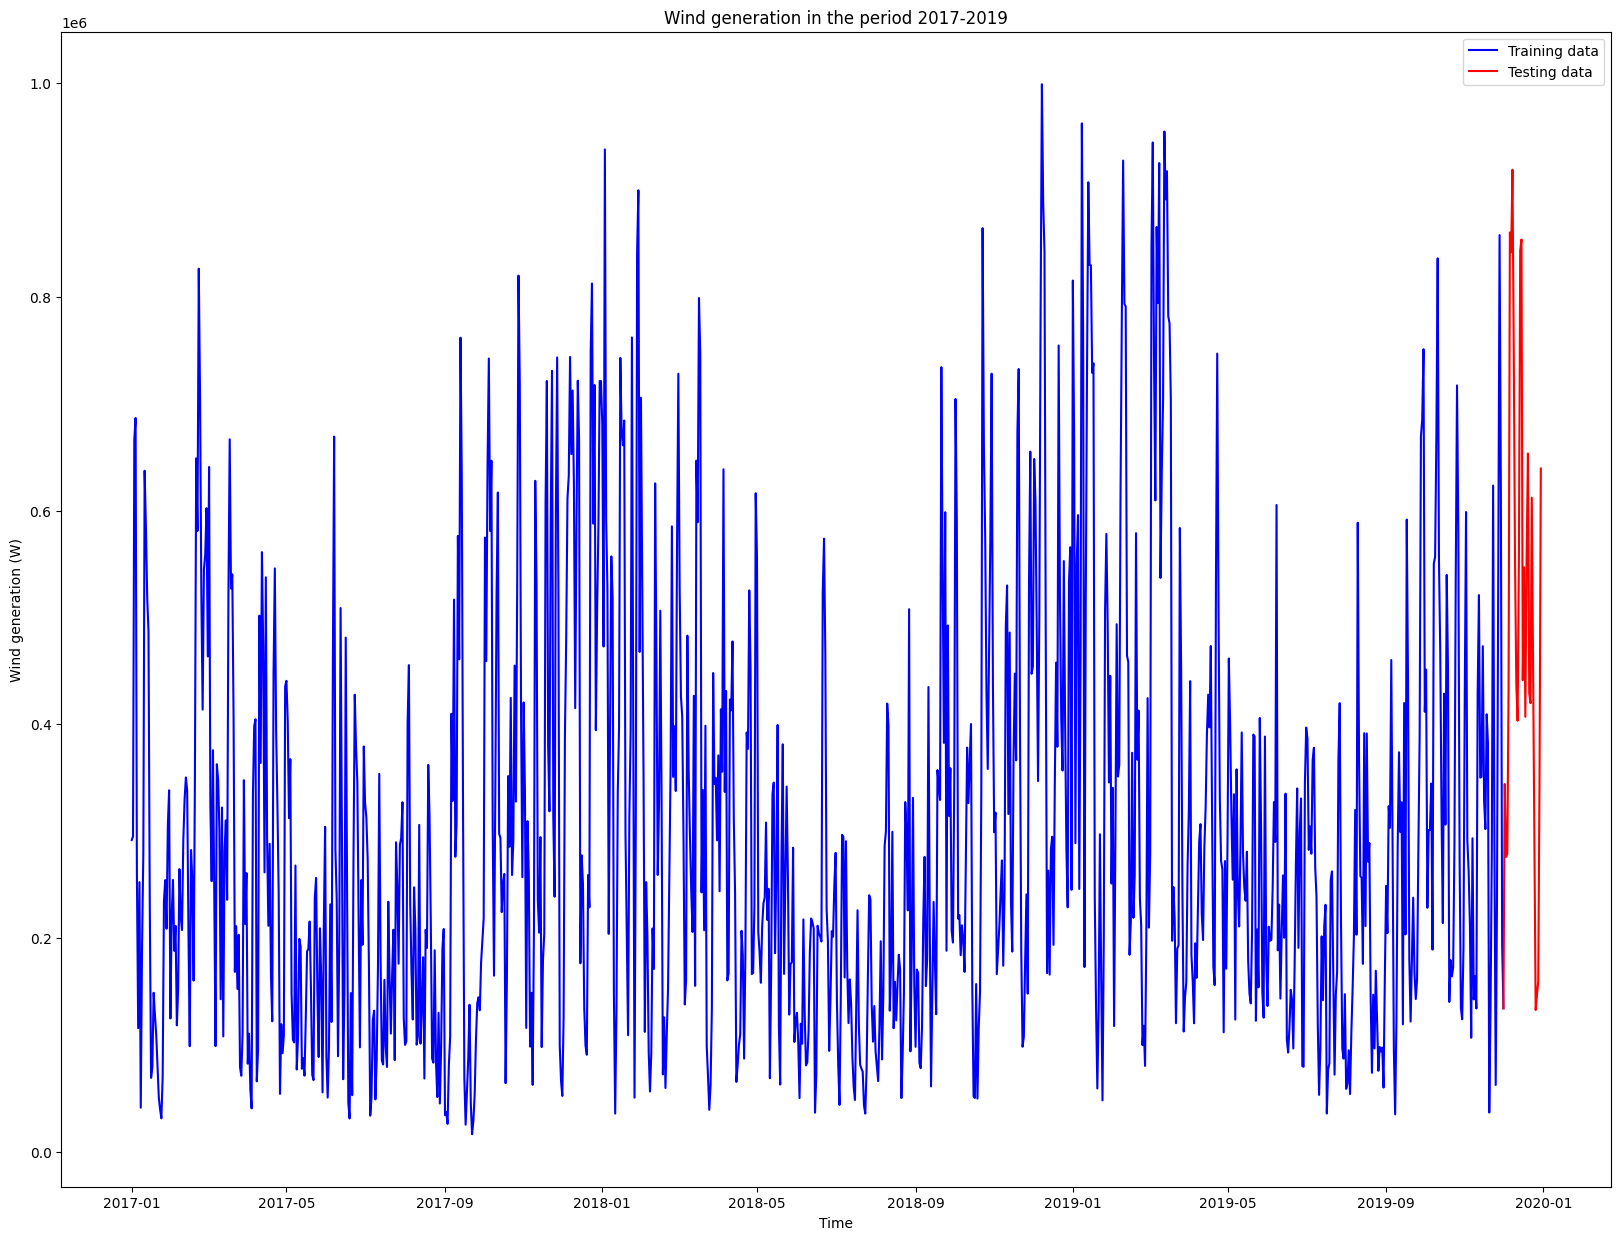

In [130]:
#Replot of the data we are intersted in forecasting.
plt.figure(figsize=(20,15))
plt.plot(train_data['wind_generation_actual'], color = 'blue', label='Training data')
plt.plot(test_data['wind_generation_actual'], color = 'red', label='Testing data')
plt.ylabel("Wind generation (W)")
plt.xlabel('Time')
plt.title("Wind generation in the period 2017-2019")
plt.legend()
plt.show()

**STATIONARITY**

In time series analysis, many modelling techniques assume that the data are stationary. A time series is stationary when its statistical characteristics (mean, variance, autocorrelation) do not change over time.
To determine if our data is stationary or not we have to use the KPSS (Kwiatkowski-Phillips-Schmidt-Shin) and the ADFuller tests which have different hypothesis and can be done separated.

In [158]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

def adfuller_test(series):
    adf_test = adfuller(series, autolag='AIC') #AIC is the default option
    print('ADF Statistic is:', adf_test[0])
    print('p-value is:', adf_test[1])
    print('Critical value is:', adf_test[4])
    if adf_test[1] <= 0.05:
        print('We can reject the null hypothesis (HO). So the data is stationary')
    else:
        print('We can NOT reject the null hypothesis (H0). So the data is NOT stationary')

def kpss_test(series):
    kpss_result = kpss(series, regression='ct', nlags='auto', store=True)
    print('KPSS Statistic is:', kpss_result[0])
    print('p-value is:', kpss_result[1])
    if kpss_result[1] <= 0.05:
        print('We can reject the null hypothesis (HO). So the data is NOT trend stationary')
    else:
        print('We can NOT reject the null hypothesis. So the data is stationary')
 


In [159]:
adfuller_test(wind_generation_train)
kpss_test(wind_generation_train)

ADF Statistic is: -10.77088114757016
p-value is: 2.3860555693459754e-19
Critical value is: {'1%': -3.436528314312484, '5%': -2.86426792284943, '10%': -2.568222448164332}
We can reject the null hypothesis (HO). So the data is stationary
KPSS Statistic is: 0.16055636659786887
p-value is: 0.037869694501775936
We can reject the null hypothesis (HO). So the data is NOT trend stationary


In the ADFuller test, the p-value is less than 0.05, so we can reject the null hypothesis and the data is stationary. 
But for the KPSS test, the p-vale is less that 0.05, so we can reject the null hyppthesist, so the data is NON trend stationary and so we have to do some differencing to get the stationary; it's usually adviced to remuve first the seasonality part and then do the differencing.

**FREQUENCY ANALYSIS**

   Frequency       Density      Period
0   0.002817  6.622174e+12  355.000000
1   0.006573  1.146676e+11  152.142857
2   0.011268  3.955245e+11   88.750000
3   0.014085  1.126715e+11   71.000000
4   0.015962  1.434301e+11   62.647059


Text(0, 0.5, 'Power')

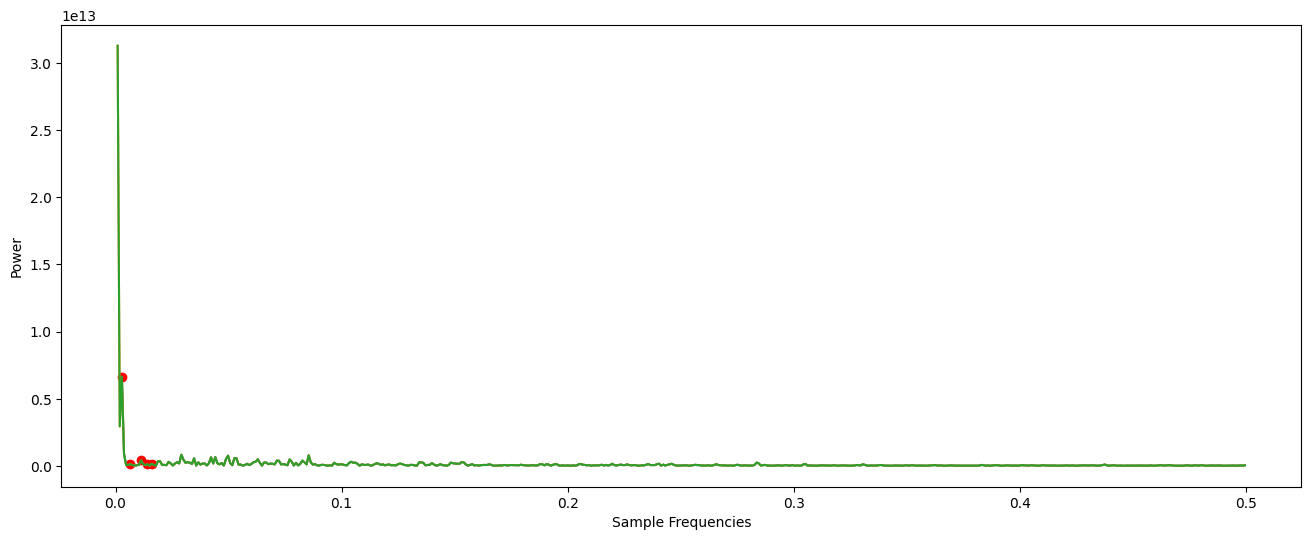

In [133]:
###Retrieve the seasonlity by using the periodogram and getting the most used frequencies.
f_per, Pxx_per = signal.periodogram(wind_generation_train,1,detrend=None,window='hann',return_onesided=True,scaling='density')
f_per = f_per[1:]
Pxx_per = Pxx_per[1:]

#Find the peaks of the periodogram.
peaks = signal.find_peaks(Pxx_per[f_per >= 0], prominence=100000)[0]
peak_freq = f_per[peaks]
peak_dens = Pxx_per[peaks]

#Plot of the analysis transformation and of its peaks. Only the first five are interestings
fig = plt.figure(figsize=(16,6))

plt.plot(peak_freq[:5], peak_dens[:5], 'ro');
plt.plot(f_per[2:],Pxx_per[2:])

#Retrieving of the values
data = {'Frequency': peak_freq, 'Density': peak_dens, 'Period': 1/peak_freq}
df = pd.DataFrame(data)

print(df.head())
sns.lineplot(x=f_per,y=Pxx_per)
plt.plot(f_per, Pxx_per)
plt.xlabel('Sample Frequencies')
plt.ylabel('Power')

We see that the most highest frquencies represents the periods 355, 152, 88, 71 and 62 days. So we have five guesses for the seasonalities, it's common that a time series has more than one seasonality. For mine purpose i'll use the seasonality of 355 approximated to 365 (yearly seasonality) and then the 88 approximated do 90 (three month seasonality.)

**APPLY SEASONAL DIFFERENCE TO OUR DATA**

Since the data is not stationary, we have to do a difference on the starting dataset. From the spectral analysis we have that the most recurrent period is 355, which can be seen as yearly seasonality.
So, we are going to do a difference of 365 to the data and then test if it is stationary.

Text(0.5, 1.0, 'Wind Energy Generation diffed 365')

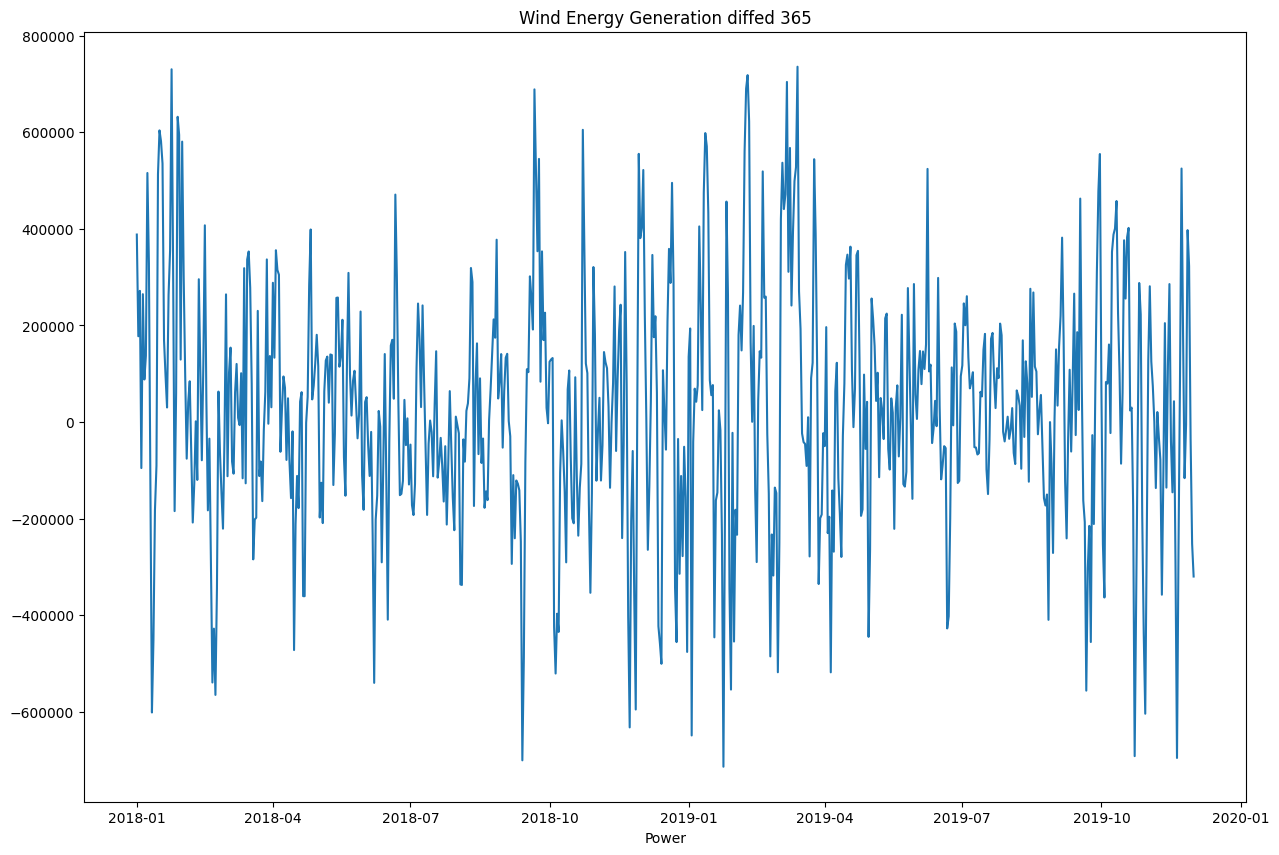

In [160]:
wind_generation_diff_train = wind_generation_train.diff(365).dropna()
train_data_diff = train_data.diff(365).dropna()
plt.figure(figsize=(15,10))
plt.plot(wind_generation_diff_train)
plt.xlabel('Power')
plt.title('Wind Energy Generation diffed 365')

We now apply the stationary test to see if this is enough to make our data stationary.

In [161]:
adfuller_test(wind_generation_diff_train)
kpss_test(wind_generation_diff_train)

ADF Statistic is: -13.767585382019107
p-value is: 9.818651975747313e-26
Critical value is: {'1%': -3.439753311961436, '5%': -2.8656896390914217, '10%': -2.568979777013325}
We can reject the null hypothesis (HO). So the data is stationary
KPSS Statistic is: 0.06629966536457012
p-value is: 0.1
We can NOT reject the null hypothesis. So the data is stationary


Now, the data is stationary!

**ACF and PACF**

The autocorrelation measures the linear relationship between lagged values of a time series. The tools that can be used to detect the properties of time series are the *ACF* and *PACF*, the AutoCorrelation Function and the Partial AutoCorrelation Function, respectively; the term auto refers to the fact that the correlation concerns the same data and not different sets. 

In [147]:
#for ACF plot
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

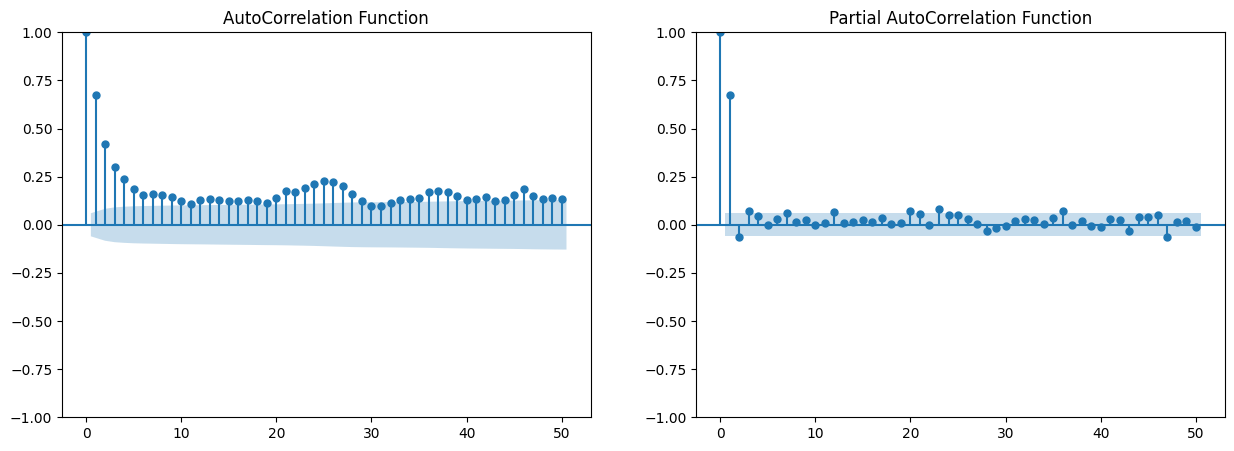

In [163]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
plot_acf(wind_generation_train, lags=50, ax=ax[0], title='AutoCorrelation Function')
plot_pacf(wind_generation_train, lags=50, ax=ax[1], title='Partial AutoCorrelation Function')
plt.show()

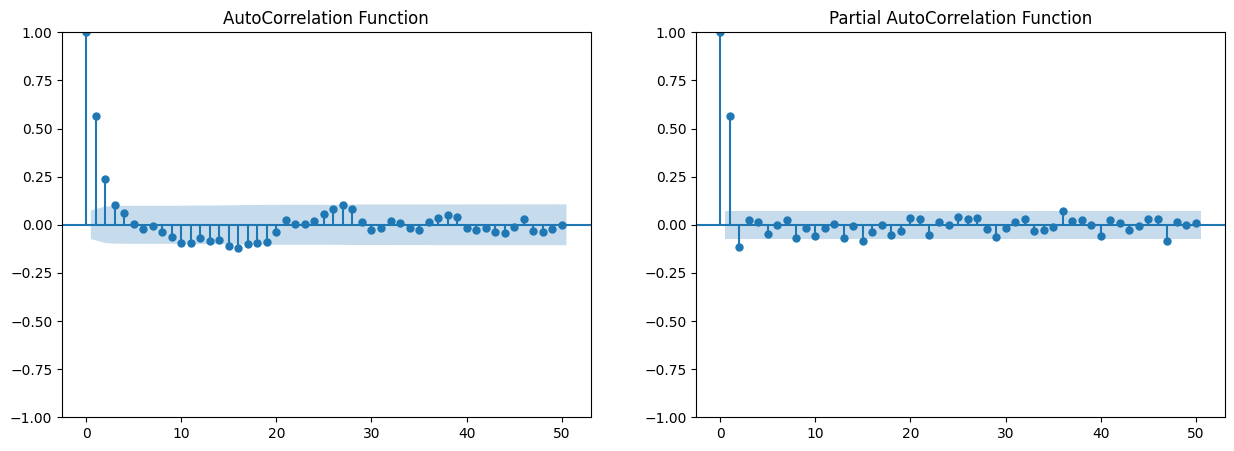

In [164]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
plot_acf(wind_generation_diff_train, lags=50, ax=ax[0], title='AutoCorrelation Function')
plot_pacf(wind_generation_diff_train, lags=50, ax=ax[1], title='Partial AutoCorrelation Function')
plt.show()

In the first case there are many outliers that lie outside the ‘confidence interval’ and this means that many data at different lags are correlated with each other, which is not the case in the second case after differentiation of the data.

**MATRICS TABLE**

I've decide to used a dataframe to save all the values and properties of each model.

In [165]:
metrics_df = pd.DataFrame(columns= ['Model_name', 'AIC', 'MAE', 'RMSE', 'MAPE'])
display(metrics_df)

,Model_name,AIC,MAE,RMSE,MAPE


**MODELS**

**1. MANUAL SARIMA**

In [167]:
from pmdarima import auto_arima
# Identify the best SARIMA model using auto_arima
optimal_sarima = auto_arima(wind_generation_diff_train,
                            seasonal=True,
                            m=12,  # Adjust seasonality (m=12 for monthly data, m=7 for weekly data)
                            max_p=4, max_q=4, max_P=4, max_Q=4,
                            stepwise=True,  # Faster search
                            trace=True,  # Show progress
                            suppress_warnings=True,  # Ignore warnings
                            error_action='ignore',  # Ignore errors in model fitting
                            information_criterion='aic')  # Optimize based on AIC

# Print the best model parameters
print(f"\nOptimal SARIMA Model: {optimal_sarima.order} x {optimal_sarima.seasonal_order}")


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=19113.507, Time=1.63 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=19379.886, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=19115.027, Time=0.24 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=19149.011, Time=0.36 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=19387.193, Time=0.03 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=19111.529, Time=1.50 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=19109.753, Time=0.95 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=19111.529, Time=1.51 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=19107.882, Time=0.14 sec
 ARIMA(1,0,2)(1,0,0)[12] intercept   : AIC=19109.629, Time=0.56 sec
 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=19109.647, Time=0.84 sec
 ARIMA(1,0,2)(1,0,1)[12] intercept   : AIC=19111.482, Time=1.67 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : AIC=19110.228, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=19105.893, Time=0.08 sec
 ARIM

In [168]:
# Fit the optimal SARIMA model
sarima_model = SARIMAX(train_data['wind_generation_actual'],
                       order=optimal_sarima.order,
                       seasonal_order=optimal_sarima.seasonal_order,
                       enforce_stationarity=False,
                       enforce_invertibility=False)

In [170]:
sarima_results = sarima_model.fit(display=False)

                                 SARIMAX Results                                  
Dep. Variable:     wind_generation_actual   No. Observations:                 1065
Model:                   SARIMAX(1, 0, 1)   Log Likelihood              -14237.208
Date:                    Sat, 01 Feb 2025   AIC                          28480.417
Time:                            19:18:32   BIC                          28495.323
Sample:                        01-01-2017   HQIC                         28486.066
                             - 12-01-2019                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9210      0.012     79.795      0.000       0.898       0.944
ma.L1         -0.1221      0.034     -3.628      0.000      -0.188      -0.056
sigma2      2.509e+1

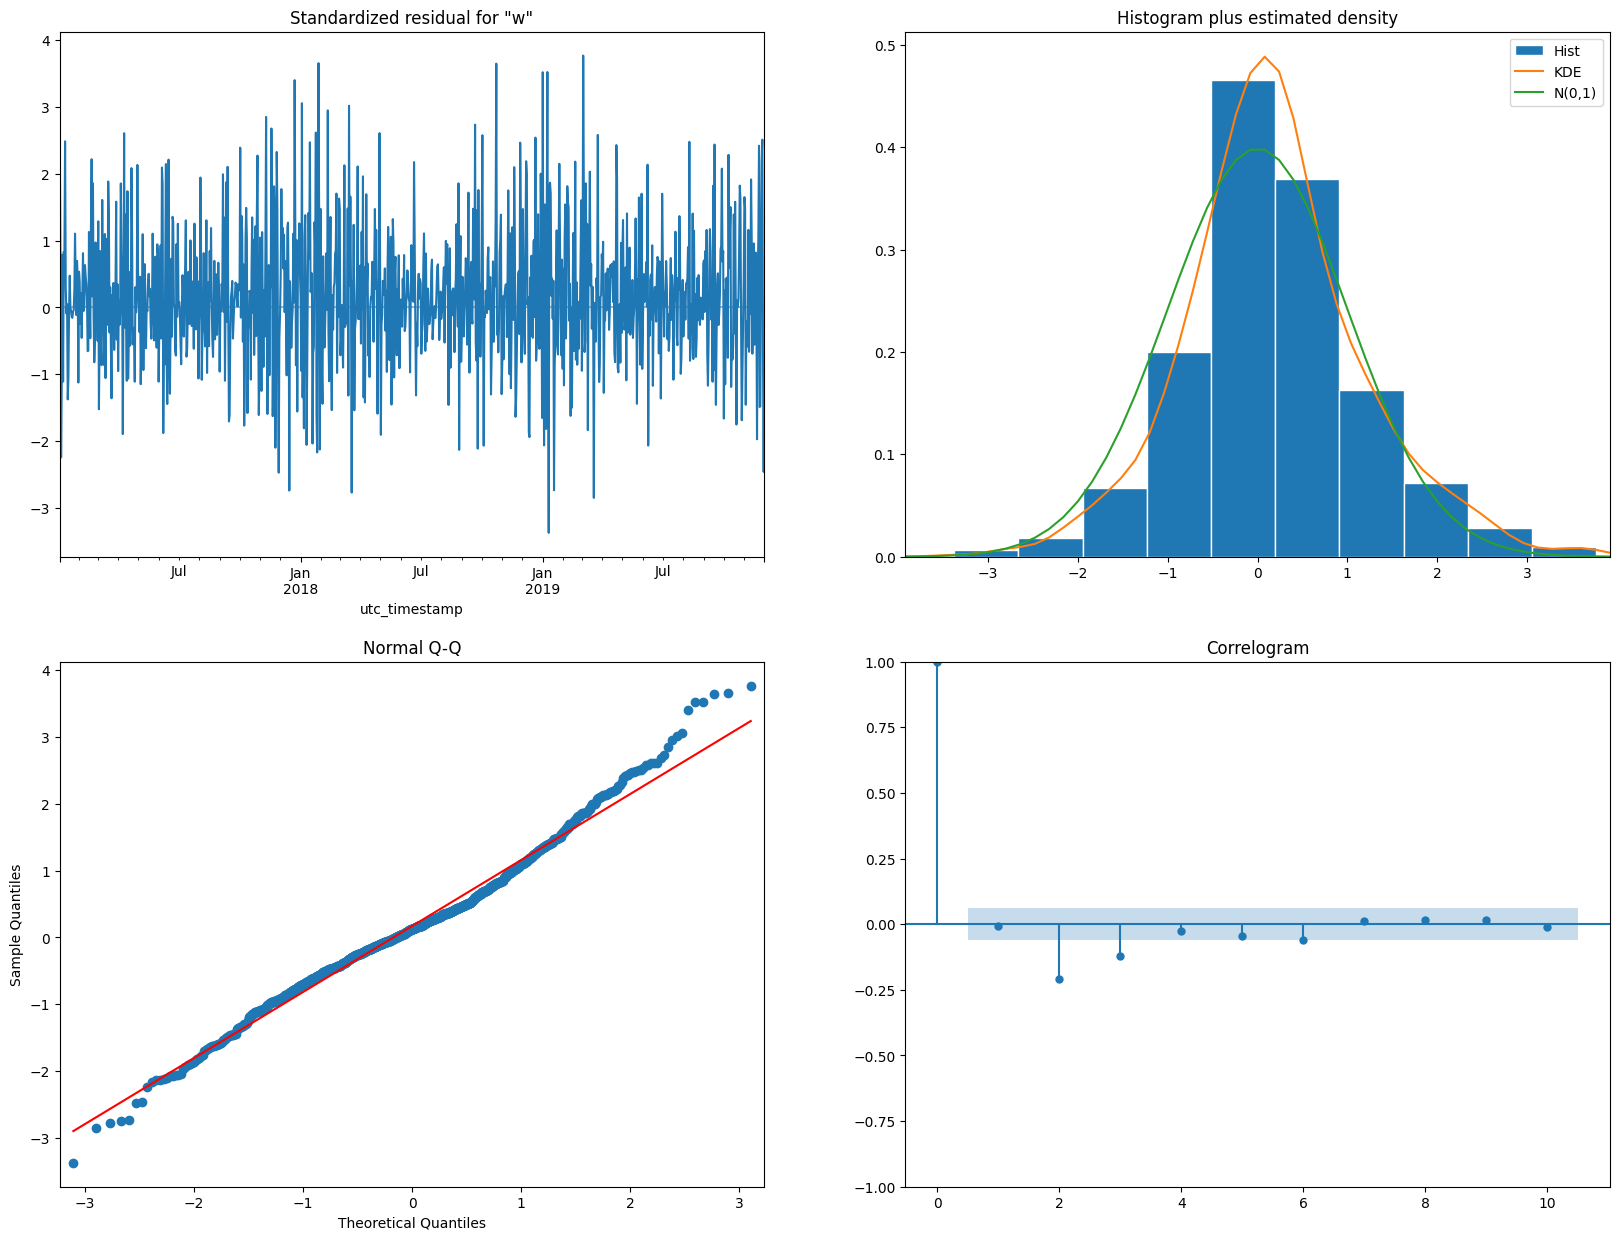

In [173]:
print(sarima_results.summary())
sarima_results.plot_diagnostics(figsize=(20,15));